In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import keras
from keras.models import Sequential
from keras.layers import Dense
import lasio
import shap
import datetime as dt

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [2]:
params = {}

In [3]:
feature_list = ['DRES', 'DT', 'GR', 'DEN', 'COND', 'CAL', 'Zone_Chalk', 'Zone_Paleocene', 'Zone_Tertiary', 'Zone_Jurassic']

In [4]:
train_X = pd.read_csv("./data/train/train_x_2021-04-23.csv", index_col=0).sample(frac=1, random_state=1)
train_y = pd.read_csv("./data/train/train_y_2021-04-23.csv", index_col=0).sample(frac=1, random_state=1)

test_x = pd.read_csv("./data/test/test_x_2021-04-23.csv", index_col=0).sample(frac=1, random_state=1)
test_y = pd.read_csv("./data/test/test_y_2021-04-23.csv", index_col=0).sample(frac=1, random_state=1)

In [5]:
train_X = train_X[feature_list]
test_x = test_x[feature_list]

In [6]:
sc_x = StandardScaler()
sc_y = StandardScaler()

X_train = sc_x.fit_transform(train_X)
X_test = sc_x.transform(test_x)

y_train = sc_y.fit_transform(train_y)
y_test = sc_y.transform(test_y)

In [7]:
input_neuron = len(test_x.columns)

In [325]:
# 40 minutes for >120,000 rows and 8 train columns, 1000 epochs

## Setup the model for training.
classifier = Sequential()
classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = input_neuron))
classifier.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
keras.layers.Dropout(0.2)
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
keras.layers.Dropout(0.2)
classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
#keras.layers.Dropout(0.2)
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'linear'))

classifier.compile(optimizer = 'SGD', loss = 'mean_squared_error', metrics = ['MAE'])
history = classifier.fit(X_train, y_train, batch_size = 128, epochs = 100, validation_split= 0.2)

Train on 136336 samples, validate on 34085 samples
Epoch 1/100
136336/136336 [==============================] - 3s 21us/step - loss: 0.9985 - MAE: 0.6959 - val_loss: 1.0064 - val_MAE: 0.6978
Epoch 2/100
136336/136336 [==============================] - 2s 13us/step - loss: 0.9985 - MAE: 0.6958 - val_loss: 1.0066 - val_MAE: 0.7014
Epoch 3/100
136336/136336 [==============================] - 2s 14us/step - loss: 0.9985 - MAE: 0.6960 - val_loss: 1.0064 - val_MAE: 0.6991
Epoch 4/100
136336/136336 [==============================] - 2s 13us/step - loss: 0.9985 - MAE: 0.6957 - val_loss: 1.0066 - val_MAE: 0.7013
Epoch 5/100
136336/136336 [==============================] - 2s 13us/step - loss: 0.9985 - MAE: 0.6958 - val_loss: 1.0067 - val_MAE: 0.7028
Epoch 6/100
136336/136336 [==============================] - 2s 14us/step - loss: 0.9985 - MAE: 0.6960 - val_loss: 1.0066 - val_MAE: 0.7016
Epoch 7/100
136336/136336 [==============================] - 2s 13us/step - loss: 0.9985 - MAE: 0.6960 - val_

In [51]:
if os.path.exists("./model") is False:
    os.mkdir("./model")
pickle.dump(classifier, open("./model/ReinNN_RMSE_64_SGD_" + str(dt.datetime.today().strftime('%Y-%m-%d'))+ ".pkl", "wb"))
pickle.dump(sc_x, open('./model/X_scaler_RMSE_64_SGD_' +str(dt.datetime.today().strftime('%Y-%m-%d'))+ '.pkl', 'wb'))
pickle.dump(sc_y, open('./model/Y_scaler_RMSE_64_SGD_' +str(dt.datetime.today().strftime('%Y-%m-%d'))+ '.pkl', 'wb'))

In [55]:
classifier = pickle.load(open("./model/ReinNN_RMSE_1024_2021-04-23.pkl", "rb"))
sc_x = pickle.load(open("./model/X_scaler_RMSE_1024_2021-04-23.pkl", "rb"))
sc_y = pickle.load(open("./model/Y_scaler_RMSE_1024_2021-04-23.pkl", "rb"))

ValueError: Unknown metric function: {'class_name': 'RootMeanSquaredError', 'config': {'name': 'root_mean_squared_error', 'dtype': 'float32'}}

In [13]:
X_rand = train_X.sample(frac=0.032, random_state=42)

rand_X = sc_x.fit_transform(X_rand)
len(rand_X)

4867

In [14]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.DeepExplainer(classifier, rand_X)
shap_values = explainer.shap_values(rand_X)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


keras is no longer supported, please use tf.keras instead.


In [15]:
# Get the column names to label the table
names= train_X.columns.to_list()

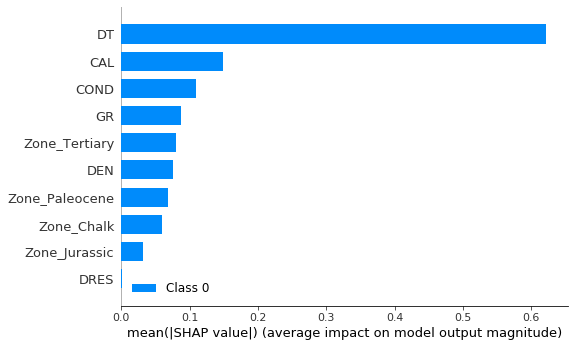

In [16]:
shap.summary_plot(shap_values, rand_X, names, plot_type="bar", show=False)
folder_create = os.path.exists("images")
if folder_create is False:
    os.mkdir("./images")
plt.savefig('./images/SHAP_Feature_Score_300dpi.png',format = "png",dpi = 300,bbox_inches = 'tight')

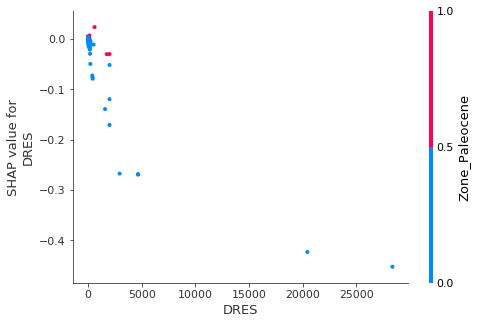

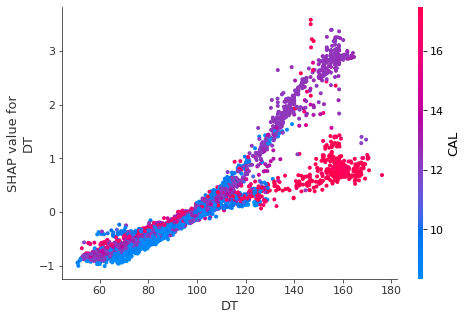

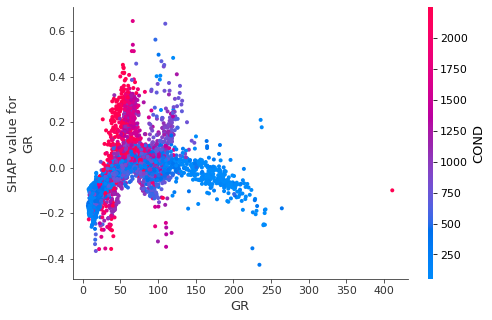

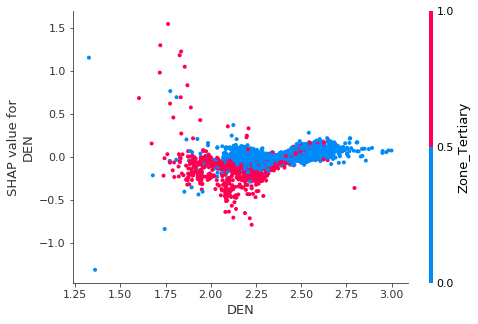

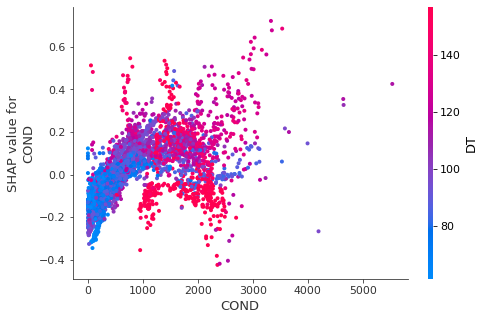

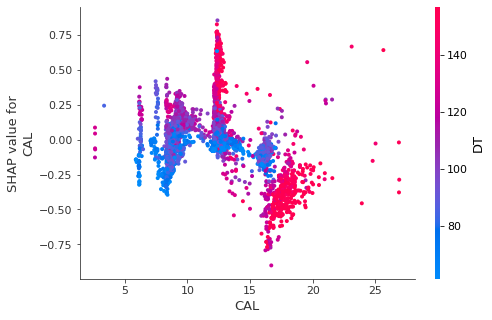

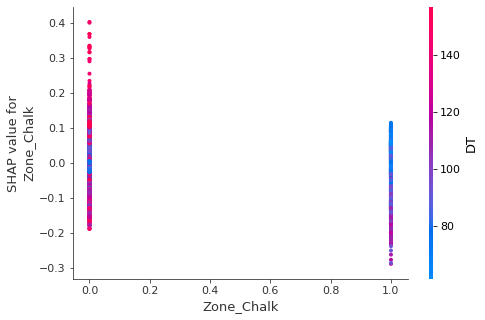

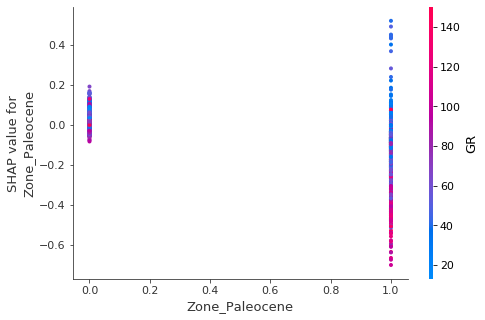

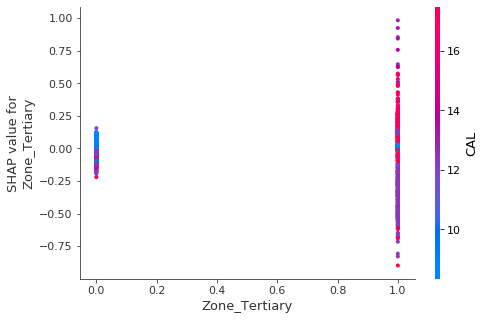

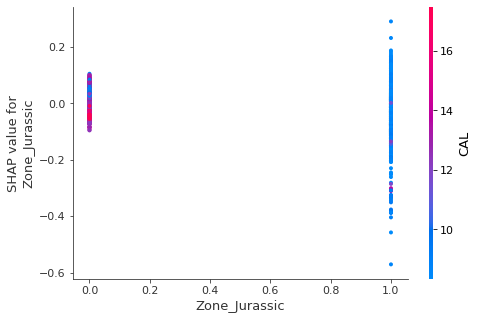

In [17]:
for i in names:
    # SHAP asigned value for an input parameter vs its value. Coloured by a random input feature
    shap.dependence_plot(i, shap_values[0], X_rand)

In [18]:
shap.force_plot(explainer.expected_value, shap_values[0], train_X)

shap.force_plot is slow for many thousands of rows, try subsampling your data.


In [19]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], train_X.iloc[0,:], link="logit")

In [326]:
test_x["DTS_pred"] = sc_y.inverse_transform(classifier.predict(X_test))
test_x['DTS_linear'] = lin_reg.predict(np.array(test_x['DT']).reshape(len(test_x),1))
test_x['DTS_poly'] = lin_reg2.predict(poly_reg.fit_transform(np.array(test_x['DT']).reshape(len(test_x),1)))

In [327]:
df = pd.concat([test_x, test_y], axis=1)
df["model_error"] = df.DTS -  df.DTS_pred

In [328]:
print(f"Neural Net MAE score: {np.round(mean_absolute_error(df.DTS, df.DTS_pred), 1)}")
print(f"Neural Net RMSE score: {np.round(mean_squared_error(df.DTS, df.DTS_pred, squared=False), 1)}")
print(f"Neural Net R2 score: {np.round(r2_score(df.DTS, df.DTS_pred), 4)}")
print(f"Linear MAE score: {np.round(mean_absolute_error(df.DTS, df.DTS_linear))}")
print(f"Linear RMSE score: {np.round(mean_squared_error(df.DTS, df.DTS_linear, squared=False), 1)}")
print(f"Linear R2 score: {np.round(r2_score(df.DTS, df.DTS_linear), 4)}")
print(f"Polynomial MAE score: {np.round(mean_absolute_error(df.DTS, df.DTS_poly))}")
print(f"Polynomial RMSE score: {np.round(mean_squared_error(df.DTS, df.DTS_poly, squared=False), 1)}")
print(f"Polynomial R2 score: {np.round(r2_score(df.DTS, df.DTS_poly), 4)}")

Neural Net MAE score: 33.2
Neural Net RMSE score: 66.3
Neural Net R2 score: 0.7222
Linear MAE score: 36.0
Linear RMSE score: 58.8
Linear R2 score: 0.7816
Polynomial MAE score: 32.0
Polynomial RMSE score: 55.0
Polynomial R2 score: 0.8086


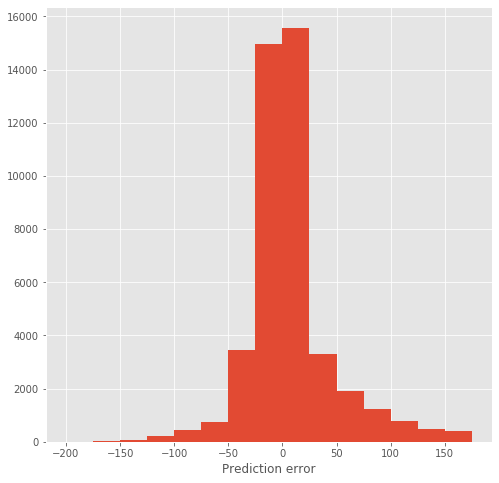

In [329]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 8))
plt.hist(df["model_error"], bins=np.arange(-200, 200,25))
plt.xlabel("Prediction error")
folder_create = os.path.exists("images")
if folder_create is False:
    os.mkdir("./images")
plt.savefig('./images/Erro_Histogram_300dpi.png',format = "png",dpi = 300,bbox_inches = 'tight')

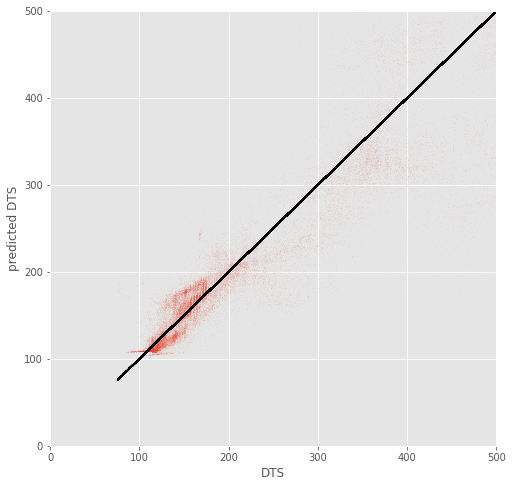

In [330]:
plt.figure(figsize=(8, 8))
plt.scatter(df.DTS, df.DTS_pred, s=0.001)
plt.plot(df.DTS, df.DTS, color="black", linestyle="--")
plt.ylim(0, 500)
plt.xlim(0, 500)
plt.xlabel("DTS")
plt.ylabel("predicted DTS")
folder_create = os.path.exists("images")
if folder_create is False:
    os.mkdir("./images")
#plt.savefig('./images/Real_vs_Predicted_300dpi.png',format = "png",dpi = 300,bbox_inches = 'tight')

In [331]:
### Import master df
df_global = pd.read_csv('.\Data\Quads_20_21_22_clean.csv', index_col=0)
df_features = df_global[feature_list].copy()
df_dts = df_global.drop(feature_list, axis=1)

In [332]:
### Create scaled array of full df
sc_df = StandardScaler()
df_global_sc = sc_df.fit_transform(df_features)

In [333]:
# Import dataset and create series from pandas table
X = np.array(df_global['DT']).reshape(len(df_global),1)
y = np.array(df_global['DTS']).reshape(len(df_global),1)
# Fit Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
# Fit Polynomial Regression
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg
X_poly = poly_reg.fit_transform(X)
# Fit lin_reg2
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Text(0, 0.5, 'DTS')

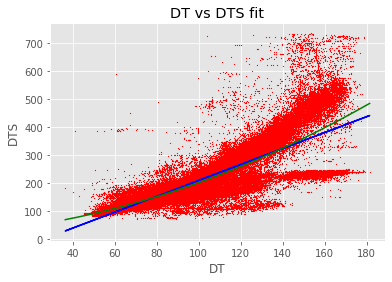

In [334]:
# Plot the Linear Results
plt.scatter(X, y, color='red', s=0.5)
plt.plot(X, lin_reg.predict(X), color='blue')
X_grid = np.arange(min(X), max(X), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)), color='green')
plt.title("DT vs DTS fit")
plt.xlabel("DT")
plt.ylabel("DTS")
## Predict a new result based on a Linear Regression
#lin_reg.predict(np.array(6.5).reshape(-1, 1))
## Predict a new result based on the polynomial regression
#lin_reg2.predict(poly_reg.fit_transform(np.array(6.5).reshape(-1, 1)))

In [335]:
### Predict shear using model
df_global['DTS_Pred'] = sc_y.inverse_transform(classifier.predict(df_global_sc))
### Use a linear and polynomial prediction autofit using scikit
df_global['DTS_linear'] = lin_reg.predict(np.array(df_global['DT']).reshape(len(df_global),1))
df_global['DTS_poly'] = lin_reg2.predict(poly_reg.fit_transform(np.array(df_global['DT']).reshape(len(df_global),1)))
### Merge and predict the error
df_global.merge(df_dts['DTS'])
df_global['model_error'] = df_global['DTS_Pred'] - df_global['DTS']

In [336]:
df_global['poly_error'] = abs(df_global['DTS'] - df_global['DTS_poly'])
df_global['linear_error'] = abs(df_global['DTS'] - df_global['DTS_linear'])

In [337]:
df_global.head(2)

Wellname   Depth       GR    CAL      DRES         COND         DT  \
0  22-6a-14Z  3852.1  22.2713  6.165  0.782710  1301.548615  94.726332   
1  22-6a-14Z  3852.2  23.2273  6.155  0.798405  1282.381443  94.811350   

        DEN         DTS  Zone_Chalk  Zone_Jurassic  Zone_Paleocene  \
0  2.493329  229.495132           1              0               0   
1  2.494966  228.476719           1              0               0   

   Zone_Tertiary    DTS_Pred  DTS_linear    DTS_poly  model_error  poly_error  \
0              0  229.946213  195.635698  188.491600     0.451081   41.003533   
1              0  229.273071  195.877182  188.711648     0.796353   39.765071   

   linear_error  
0     33.859434  
1     32.599536

In [338]:
top_count = ['21-8-4', '21-1a-19','20-7b-5', '20-5c-11','21-24-6', '22-14b-8','22-14b-5', '22-30a-14Y','21-1a-19y']

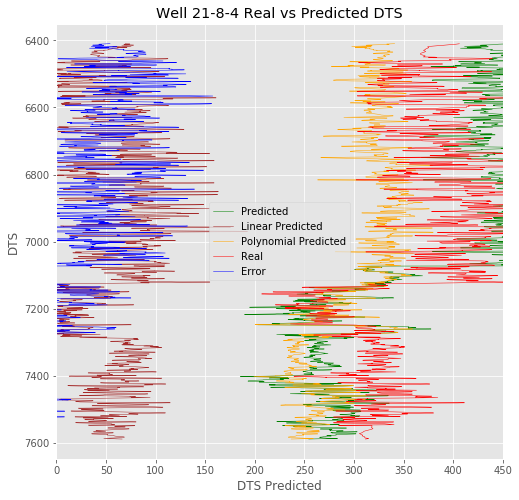

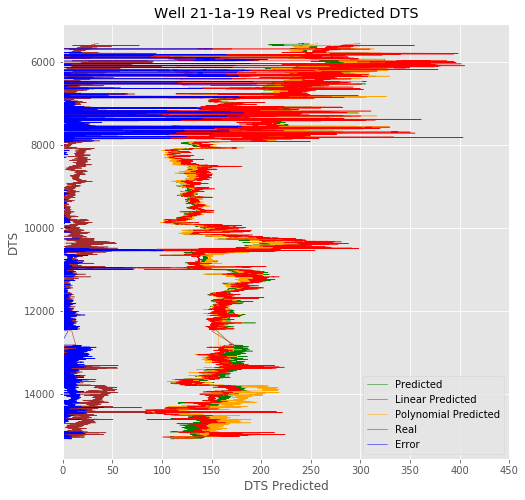

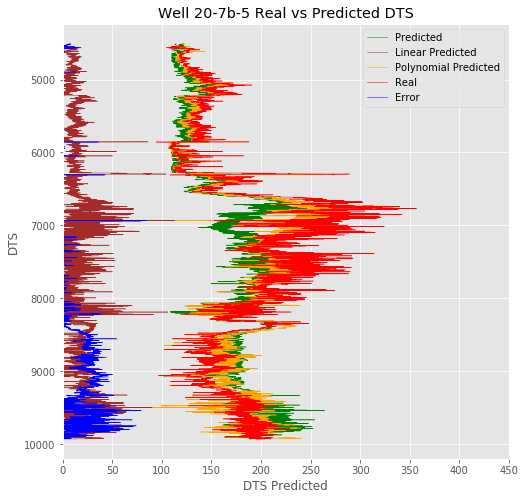

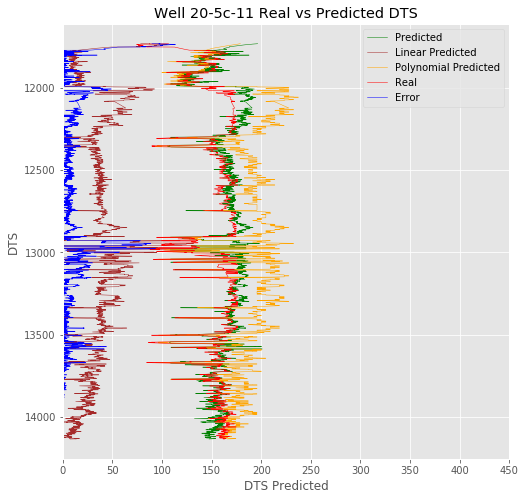

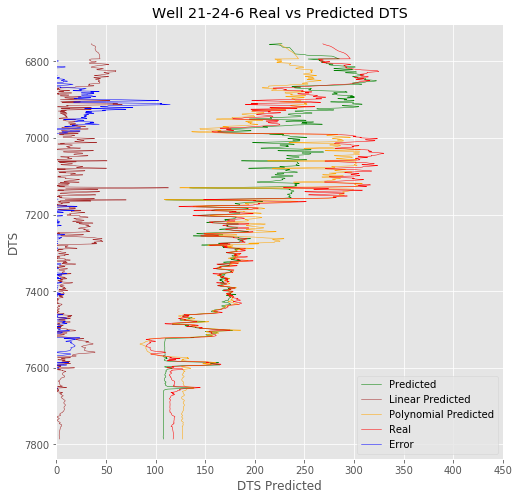

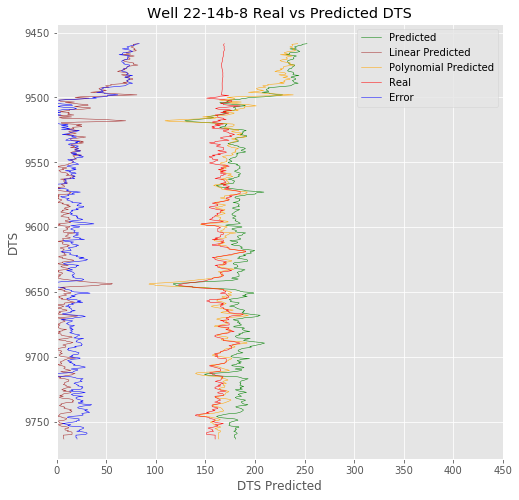

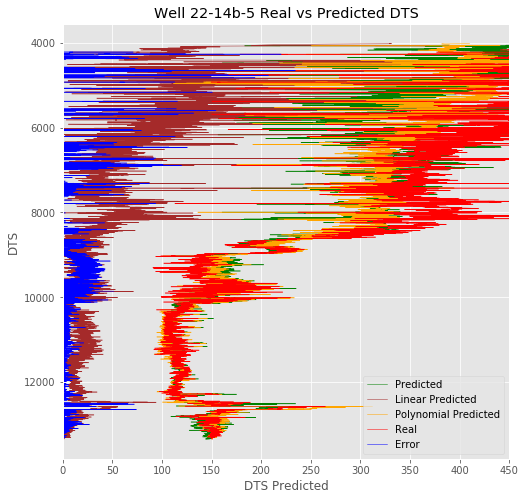

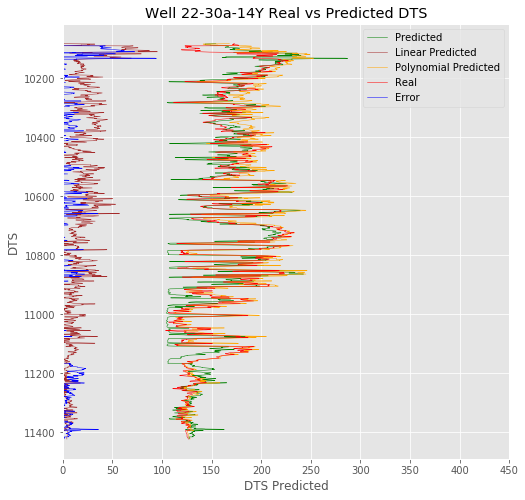

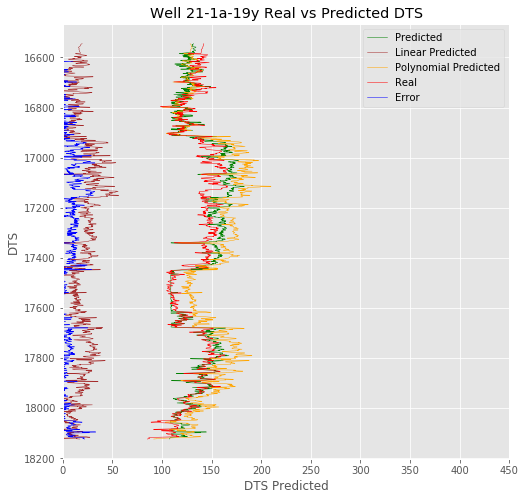

In [339]:
for well in top_count:
    plt.figure(figsize=(8, 8))
    plt.plot(df_global.loc[df_global['Wellname']==well]['DTS_Pred'], df_global.loc[df_global['Wellname']==well]['Depth'], color='green', linewidth=0.5, label='Predicted')
    plt.plot(df_global.loc[df_global['Wellname']==well]['linear_error'], df_global.loc[df_global['Wellname']==well]['Depth'], color='brown', linewidth=0.5, label='Linear Predicted')
    plt.plot(df_global.loc[df_global['Wellname']==well]['DTS_poly'], df_global.loc[df_global['Wellname']==well]['Depth'], color='orange', linewidth=0.5, label='Polynomial Predicted')
    plt.plot(df_global.loc[df_global['Wellname']==well]['DTS'], df_global.loc[df_global['Wellname']==well]['Depth'], color="red", linewidth=0.5, label='Real') #linestyle="--")
    plt.plot(df_global.loc[df_global['Wellname']==well]['model_error'], df_global.loc[df_global['Wellname']==well]['Depth'], color="blue", linewidth=0.5, label='Error') #linestyle="--")
    
    plt.xlim(0, 450)
    #plt.xscale('log')
    #plt.ylim(5000, 15500)
    plt.title('Well ' + well + ' Real vs Predicted DTS')
    plt.xlabel("DTS Predicted")
    plt.ylabel("DTS")
    plt.gca().invert_yaxis()
    plt.legend()
    #plt.savefig(str(well) + '_Real_vs_Predicted_300dpi.png',format = "png",dpi = 300,bbox_inches = 'tight')
    plt.show()

In [340]:
print(f"Neural Net MAE score: {np.round(mean_absolute_error(df_global['DTS'], df_global['DTS_Pred']))}")
print(f"Neural Net RMSE score: {np.round(mean_squared_error(df_global['DTS'], df_global['DTS_Pred'], squared=False))}")
print(f"Neural Net R2 score: {np.round(r2_score(df_global['DTS'], df_global['DTS_Pred']), 4)}")

Neural Net MAE score: 20.0
Neural Net RMSE score: 41.0
Neural Net R2 score: 0.8179


In [341]:
print(f"Neural Net MAE score: {np.round(mean_absolute_error(df_global[df_global['Zone_Paleocene']==1]['DTS'], df_global[df_global['Zone_Paleocene']==1]['DTS_Pred']))}")
print(f"Neural Net RMSE score: {np.round(mean_squared_error(df_global[df_global['Zone_Paleocene']==1]['DTS'], df_global[df_global['Zone_Paleocene']==1]['DTS_Pred'], squared=False))}")
print(f"Neural Net R2 score: {np.round(r2_score(df_global[df_global['Zone_Paleocene']==1]['DTS'], df_global[df_global['Zone_Paleocene']==1]['DTS_Pred']), 4)}")

Neural Net MAE score: 21.0
Neural Net RMSE score: 33.0
Neural Net R2 score: 0.744


In [342]:
print(f"Neural Net MAE score: {np.round(mean_absolute_error(df_global['DTS'], df_global['DTS_poly']))}")
print(f"Neural Net RMSE score: {np.round(mean_squared_error(df_global['DTS'], df_global['DTS_poly'], squared=False))}")
print(f"Neural Net R2 score: {np.round(r2_score(df_global['DTS'], df_global['DTS_poly']), 4)}")

Neural Net MAE score: 30.0
Neural Net RMSE score: 52.0
Neural Net R2 score: 0.6977


In [343]:
print(f"Neural Net MAE score: {np.round(mean_absolute_error(df_global[df_global['Zone_Paleocene']==1]['DTS'], df_global[df_global['Zone_Paleocene']==1]['DTS_poly']))}")
print(f"Neural Net RMSE score: {np.round(mean_squared_error(df_global[df_global['Zone_Paleocene']==1]['DTS'], df_global[df_global['Zone_Paleocene']==1]['DTS_poly'], squared=False))}")
print(f"Neural Net R2 score: {np.round(r2_score(df_global[df_global['Zone_Paleocene']==1]['DTS'], df_global[df_global['Zone_Paleocene']==1]['DTS_poly']), 4)}")

Neural Net MAE score: 25.0
Neural Net RMSE score: 36.0
Neural Net R2 score: 0.6832


In [344]:
print(f"Neural Net MAE score: {np.round(mean_absolute_error(df_global['DTS'], df_global['DTS_linear']))}")
print(f"Neural Net RMSE score: {np.round(mean_squared_error(df_global['DTS'], df_global['DTS_linear'], squared=False))}")
print(f"Neural Net R2 score: {np.round(r2_score(df_global['DTS'], df_global['DTS_linear']), 4)}")

Neural Net MAE score: 32.0
Neural Net RMSE score: 53.0
Neural Net R2 score: 0.6904


In [345]:
print(f"Neural Net MAE score: {np.round(mean_absolute_error(df_global[df_global['Zone_Paleocene']==1]['DTS'], df_global[df_global['Zone_Paleocene']==1]['DTS_linear']))}")
print(f"Neural Net MAE score: {np.round(mean_squared_error(df_global[df_global['Zone_Paleocene']==1]['DTS'], df_global[df_global['Zone_Paleocene']==1]['DTS_linear'], squared=False))}")
print(f"Neural Net R2 score: {np.round(r2_score(df_global[df_global['Zone_Paleocene']==1]['DTS'], df_global[df_global['Zone_Paleocene']==1]['DTS_linear']), 4)}")

Neural Net MAE score: 27.0
Neural Net MAE score: 38.0
Neural Net R2 score: 0.65


In [205]:
KDE = df_global[['DT', 'DTS', 'DTS_Pred', 'DTS_linear']]

The following kwargs were not used by contour: 'edgecolor', 'linewidth'


(100, 300)

<Figure size 800x800 with 0 Axes>

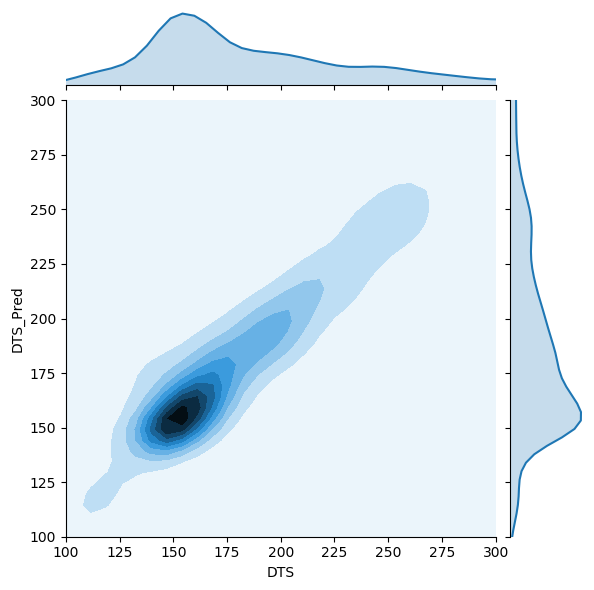

In [80]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.figure(figsize=(8, 8))
plot = sns.jointplot(x=df_global[df_global['Zone_Paleocene']==1]["DTS"], y=df_global[df_global['Zone_Paleocene']==1]["DTS_Pred"], kind='kde', edgecolor="skyblue", linewidth=2)
#plt.plot(df.DTS, df.DTS, color="black", linestyle="--")
plot.ax_marg_x.set_xlim(100, 300)
plot.ax_marg_y.set_ylim(100, 300)
#sns.ylim(100, 300)
#sns.xlim(0, 400)
#plt.savefig('./images/Real_vs_Predicted_DensityPlot_300dpi.png',format = "png",dpi = 300,bbox_inches = 'tight')

The following kwargs were not used by contour: 'edgecolor', 'linewidth'


(100, 300)

<Figure size 800x800 with 0 Axes>

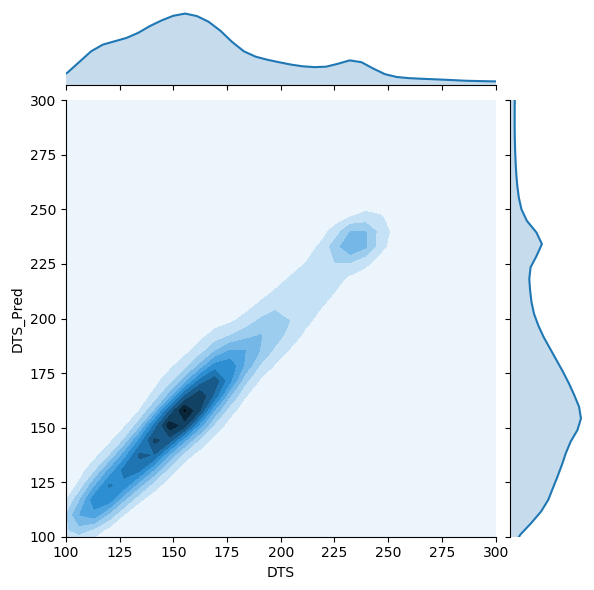

In [81]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.figure(figsize=(8, 8))
plot = sns.jointplot(x=df_global["DTS"], y=df_global["DTS_Pred"], kind='kde', edgecolor="skyblue", linewidth=2)
#plt.plot(df.DTS, df.DTS, color="black", linestyle="--")
plot.ax_marg_x.set_xlim(100, 300)
plot.ax_marg_y.set_ylim(100, 300)
#sns.ylim(100, 300)
#sns.xlim(0, 400)
#plt.savefig('./images/Real_vs_Predicted_DensityPlot_300dpi.png',format = "png",dpi = 300,bbox_inches = 'tight')

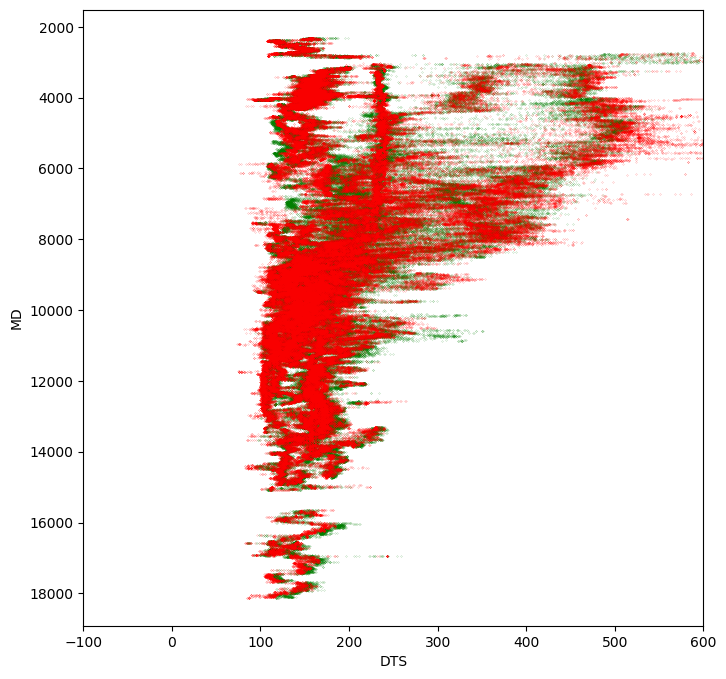

In [82]:
plt.figure(figsize=(8, 8))
plt.scatter(df_global['DTS_Pred'], df_global['Depth'], s=0.01, color='green', label='Predicted')
plt.scatter(df_global['DTS'], df_global['Depth'], color="red", s=0.01, label='Real') #linestyle="--")


plt.xlim(-100, 600)
#plt.ylim(5000, 15500)
plt.xlabel("DTS")
plt.ylabel("MD")
plt.gca().invert_yaxis()

plt.savefig('DTS_vs_DTSpred_300dpi.png',format = "png",dpi = 300,bbox_inches = 'tight')
plt.show()

In [83]:
well_stats = pd.DataFrame()
for i in df_global['Wellname'].unique():
    blank_df=pd.DataFrame()
    temp_error = df_global.loc[df_global['Wellname']==i]['model_error'].mean()
    temp_error = df_global.loc[df_global['Wellname']==i]['model_error'].mean()
    temp_corr = df_global.loc[df_global['Wellname']==i]['DTS'].corr(df_global.loc[df_global['Wellname']==i]['DT'])
    blank_df = blank_df.append({'Wellname': i, 'Mean_error': temp_error, 'DTS_DT_corr': temp_corr}, ignore_index=True)
    well_stats = pd.concat([well_stats, blank_df])

In [84]:
well_stats.head(2)

DTS_DT_corr  Mean_error   Wellname
0     0.878605    4.939237  22-6a-14Z
0     0.932971   -2.469711  22-12a-10

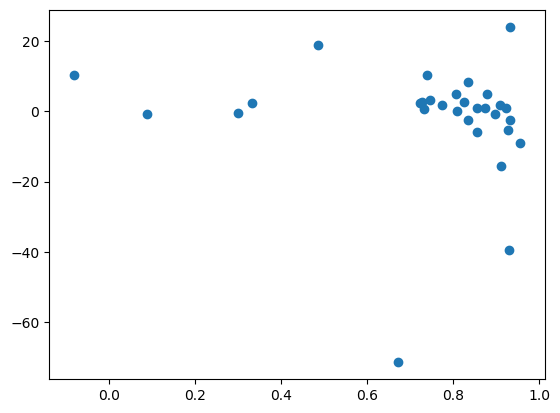

In [85]:
plt.scatter(well_stats['DTS_DT_corr'], well_stats['Mean_error'])

In [86]:
names = list(df_global.columns)

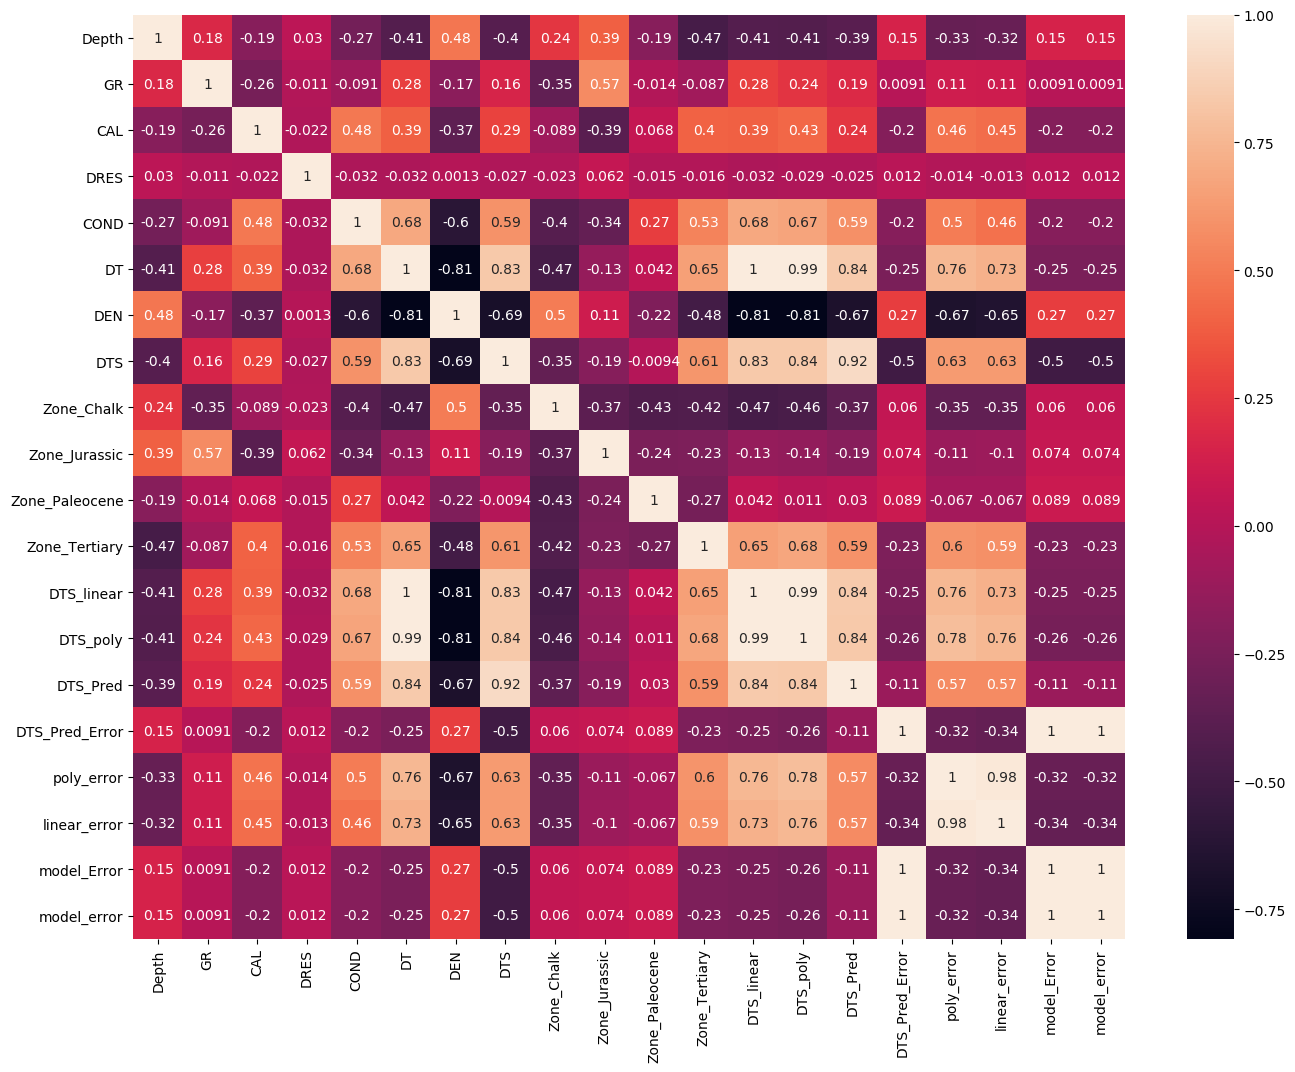

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))
sns.heatmap(df_global[names].corr(), ax=ax, annot=True)